# Australian Renewable Energy Generation


The aim of this project is to predict how much power a wind or solar farm will generate based on weather conditions.


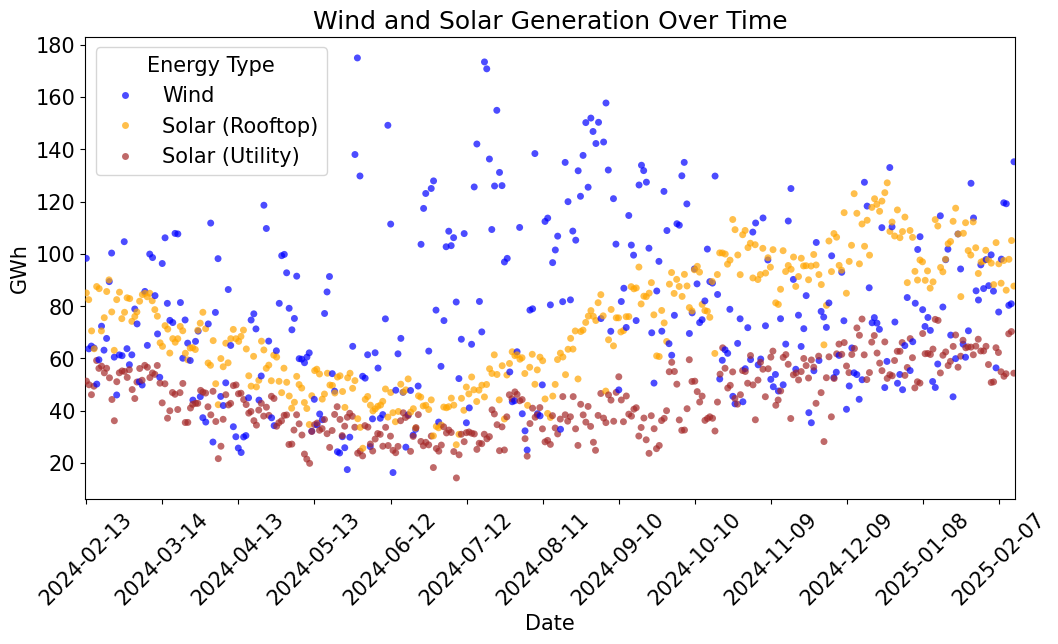

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

EnergyGeneration_df = pd.read_csv("2024EnergyGenerationAus.csv")
# print(EnergyGeneration_df.info())
# print(EnergyGeneration_df.describe())

# Visualizing the "Wind - GWh" and "Solar (Rooftop) - GWh" columns over time
# Ensure the date or time column is in datetime format & add DOY column
EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['date'])
EnergyGeneration_df['DOY'] = EnergyGeneration_df['Date'].dt.dayofyear

# Reshape data to long format for Wind and Solar
EnergyGeneration_df_long = EnergyGeneration_df.melt(
    id_vars='Date', 
    value_vars=['Wind -  GWh', 'Solar (Rooftop) -  GWh', 'Solar (Utility) -  GWh'], 
    var_name='Energy Type', 
    value_name='GWh'
)

# Simplify energy type labels
EnergyGeneration_df_long['Energy Type'] = EnergyGeneration_df_long['Energy Type'].str.replace(' -  GWh', '')

# Plot using stripplot
plt.figure(figsize=(12, 6))
sns.stripplot(
    x='Date', 
    y='GWh', 
    hue='Energy Type', 
    data=EnergyGeneration_df_long, 
    jitter=True, 
    alpha=0.7, 
    palette={'Wind': 'blue', 'Solar (Rooftop)': 'orange', 'Solar (Utility)': 'brown'}
)

# Adding plot labels and title
plt.title('Wind and Solar Generation Over Time')
plt.xlabel('Date')
plt.ylabel('GWh')
plt.xticks(rotation=45)
plt.legend(title='Energy Type')
plt.xticks(ticks=plt.xticks()[0][::30], rotation=45)

# Show plot
plt.show()

Use NASA POWER API to get weather parameters for solar and wind generation in Queensland

In [58]:
import pandas as pd
import numpy as np
import concurrent.futures
from api_fetch import fetch_weather_data

# Define Queensland's approximate lat/lon bounds for general parameters
latitudes = np.arange(-29, -10, 2)   # South QLD (-29) to North (-10) in 2-degree steps
longitudes = np.arange(138, 154, 2)  # West QLD (138) to East Coast (154) in 2-degree steps

# Define specific wind farm coordinates (latitude, longitude)
wind_farm_coords = [
    (-26.55, 151.33),  # Coopers Gap Wind Farm
    (-26.80, 150.27),  # Dulacca Wind Farm
    (-17.2, 145.4),    # Mount Emerald Wind Farm
    (-17.5922, 145.5306),  # Windy Hill Wind Farm
    (-17.06, 146.75),  # Kaban Green Power Hub
    (-21, 145)         # Kennedy Energy Park
]

# Parameters for weather data
parameters = "T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX"       # Temperature, Solar Radiation, Wind Speed at 50m and its maximum
start_date = "20240213"
end_date = "20250213"

# Store results
all_data = []

# Function to fetch weather data for a given set of parameters and location
def fetch_loc_weatherData(lat, lon, parameters, isWindFarm=False):
    print(f"Fetching data for Lat: {lat}, Lon: {lon} with parameters: {parameters}...")
    data = fetch_weather_data(
        parameters=parameters,
        latitude=lat,
        longitude=lon,
        start_date=start_date,
        end_date=end_date
    )
    if data is not None:
        data["Latitude"] = lat
        data["Longitude"] = lon
        data["isWindFarm"] = isWindFarm  # Add the isWind column
        # Convert YEAR + DOY to datetime format
        data["Date"] = pd.to_datetime(data["YEAR"].astype(str) + data["DOY"].astype(str), format="%Y%j")
    return data

# Execute API calls concurrently
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    
    # Grid locations for non-wind parameters
    for lat in latitudes:
        for lon in longitudes:
            futures.append(executor.submit(
                fetch_loc_weatherData, lat, lon, parameters, isWindFarm=False
            ))
    
    # Wind farm locations for wind parameters
    for lat, lon in wind_farm_coords:
        futures.append(executor.submit(
            fetch_loc_weatherData, lat, lon, parameters, isWindFarm=True
        ))
    
    # Collect results
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            all_data.append(result)

# Combine all results into a single DataFrame
if all_data:
    WeatherData_df = pd.concat(all_data, ignore_index=True)
    print(WeatherData_df.head())
else:
    print("No data retrieved.")

# Data Cleaning
# Remove rows with invalid values
invalid_value = -999
WeatherData_df = WeatherData_df.replace(invalid_value, np.nan).dropna()

# Drop rows in EnergyGeneration_df if no corresponding date in WeatherData_df
EnergyGeneration_clean_df = EnergyGeneration_df[EnergyGeneration_df['Date'].isin(WeatherData_df['Date'])]


Fetching data for Lat: -29, Lon: 138 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -29, Lon: 140 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -29, Lon: 142 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -29, Lon: 144 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -29, Lon: 146 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -29, Lon: 148 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -29, Lon: 150 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -29, Lon: 152 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -27, Lon: 138 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX...
Fetching data for Lat: -27, Lon: 140 with parameters: T

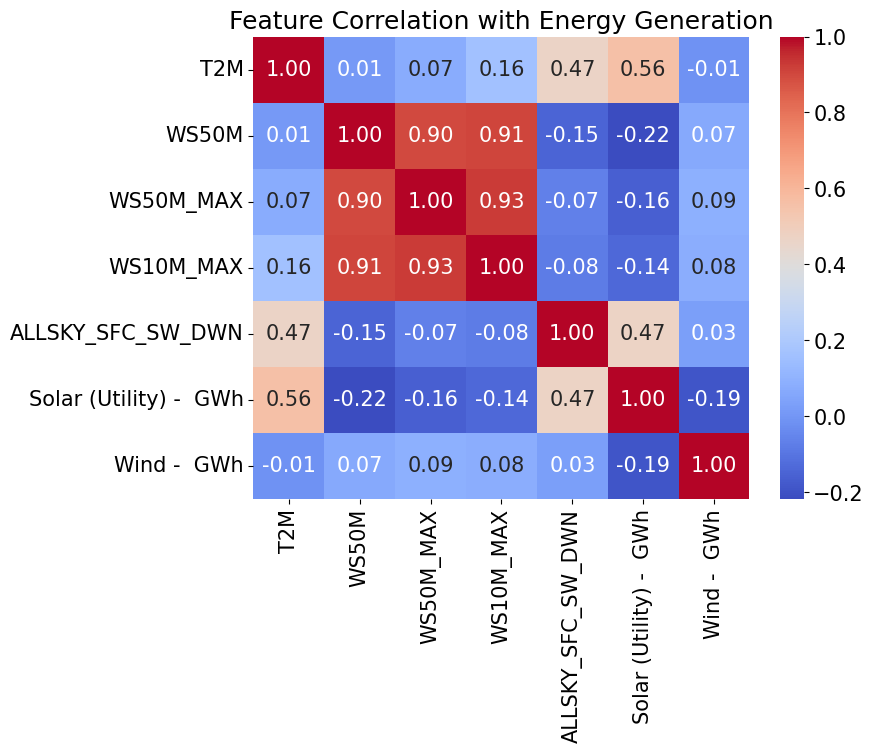

In [59]:
### Data Exploration: Check correlation between variables
import seaborn as sns
import matplotlib.pyplot as plt


# Merge WeatherData_df and EnergyGeneration_df on Date
merged_df = pd.merge(WeatherData_df, EnergyGeneration_clean_df, on="Date", how="inner")

# Select only relevant columns
correlation_matrix = merged_df[["T2M", "WS50M", "WS50M_MAX", "WS10M_MAX", "ALLSKY_SFC_SW_DWN", "Solar (Utility) -  GWh", "Wind -  GWh"]].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Energy Generation")
plt.show()


## Model Building
#### 1. Linear Regression

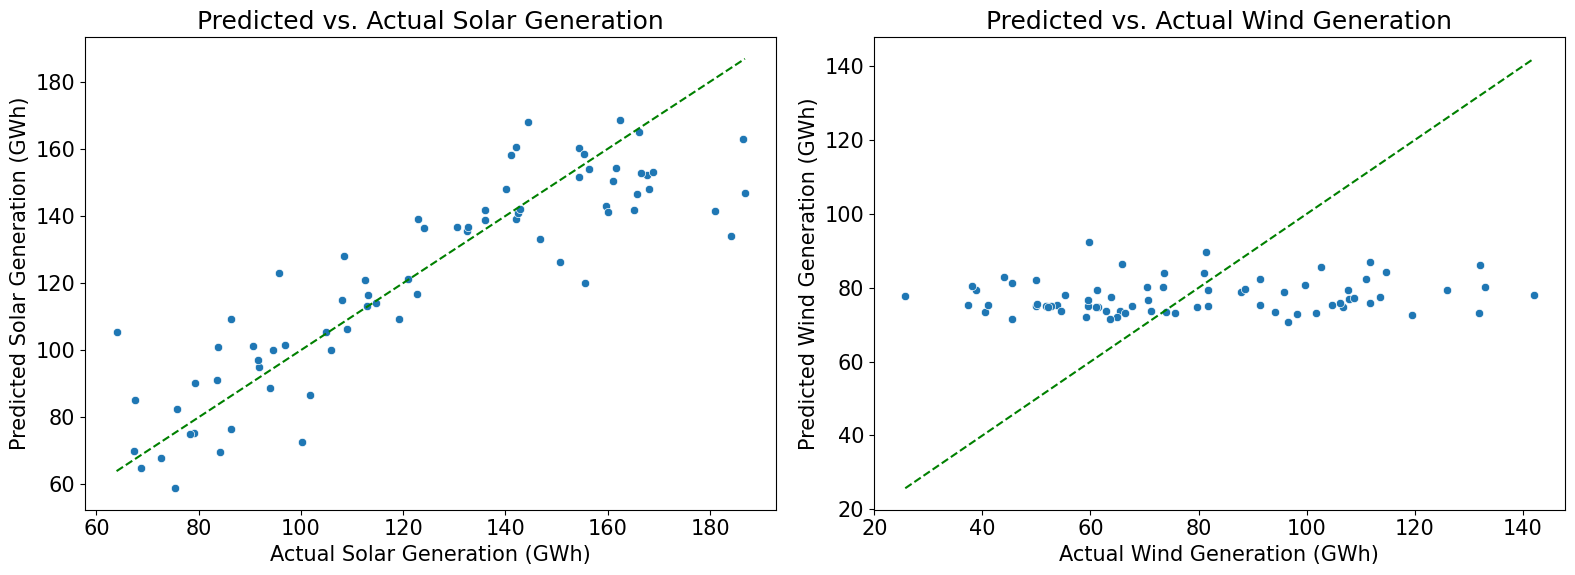

Solar MAE: 12.114315149427386
Wind MAE: 22.931747431327004


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
WeatherData_avg = WeatherData_df.groupby('DOY')[['T2M', 'ALLSKY_SFC_SW_DWN', 'WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for these parameters
EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

X = WeatherData_avg[['T2M', 'ALLSKY_SFC_SW_DWN']]
y = EnergyGeneration_clean_df['Solar (Utility) -  GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) -  GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_solar = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_solar = model.predict(X_test)




## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True] # Just select data for wind farms
WeatherData_avg_wind = WeatherData_wind.groupby('DOY')[['WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for wind speed
X = WeatherData_avg_wind[['WS10M_MAX']]  ** 3 # Wind generation is proportional to the cube of wind speed
y = EnergyGeneration_clean_df['Wind -  GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_wind = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_wind = model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))

##### Model Improvement Experiements
a. Incoorporate seasonality

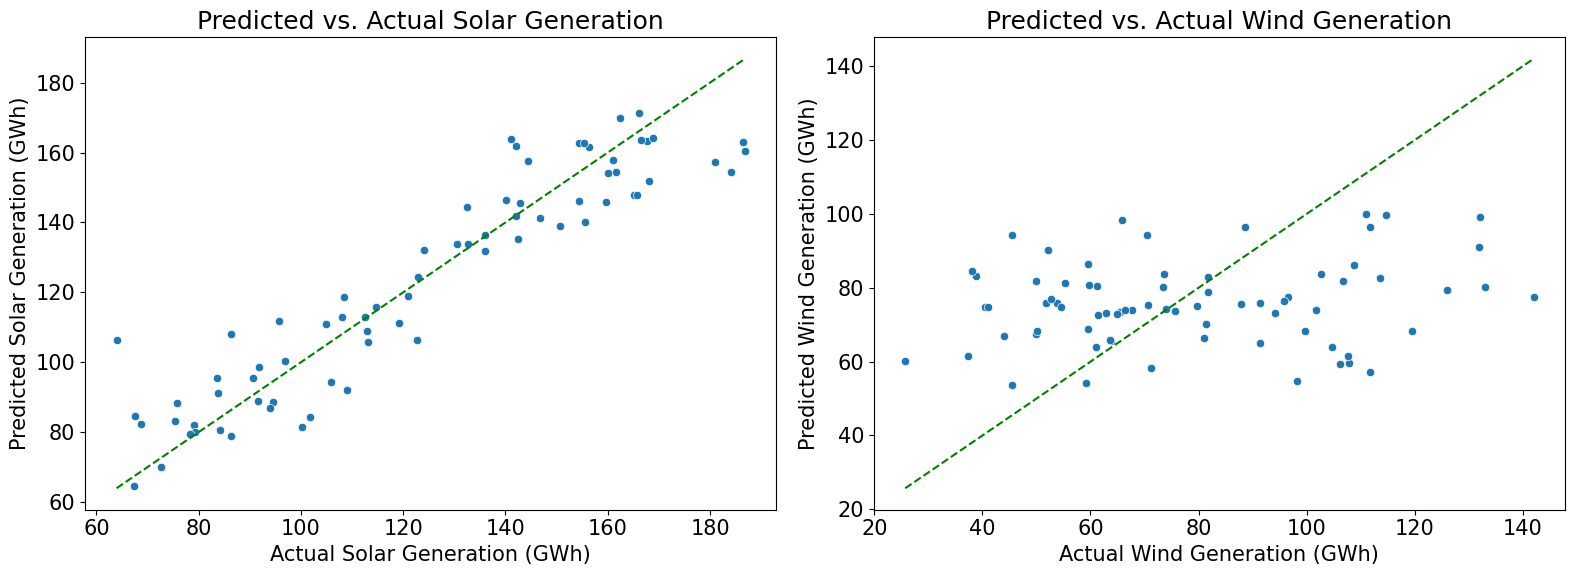

Solar MAE: 9.618227361831769
Wind MAE: 22.97502211768815


In [61]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
WeatherData_avg = WeatherData_df.groupby('DOY')[['T2M', 'ALLSKY_SFC_SW_DWN', 'WS50M_MAX', 'WS50M','WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for these parameters
EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

WeatherData_avg['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg['DOY'] / 365) # Encode DOY as sin/cos for seasonality
WeatherData_avg['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg['DOY'] / 365)

X = WeatherData_avg[['T2M', 'ALLSKY_SFC_SW_DWN' , 'DOY_sin', 'DOY_cos']]
y = EnergyGeneration_clean_df['Solar (Utility) -  GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) -  GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_solar = train_test_split(X, y, test_size=0.2, random_state=42)

Solar_LR_model = LinearRegression()
Solar_LR_model.fit(X_train, y_train)
y_pred_solar = Solar_LR_model.predict(X_test)




## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True] # Just select data for wind farms
WeatherData_avg_wind = WeatherData_wind.groupby('DOY')[['WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for wind speed
# Encode DOY as sine and cosine components to capture seasonality
WeatherData_avg_wind['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)
WeatherData_avg_wind['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)

# Select the features for the model, including DOY components and wind speed
X = WeatherData_avg_wind[['WS10M_MAX', 'DOY_sin', 'DOY_cos']] ** 3  # Wind generation is proportional to the cube of wind speed
y = EnergyGeneration_clean_df['Wind -  GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_wind = train_test_split(X, y, test_size=0.2, random_state=42)

Wind_LR_model = LinearRegression()
Wind_LR_model.fit(X_train, y_train)
y_pred_wind = Wind_LR_model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))

#### 2. Gradient Boosting (XGBoost)

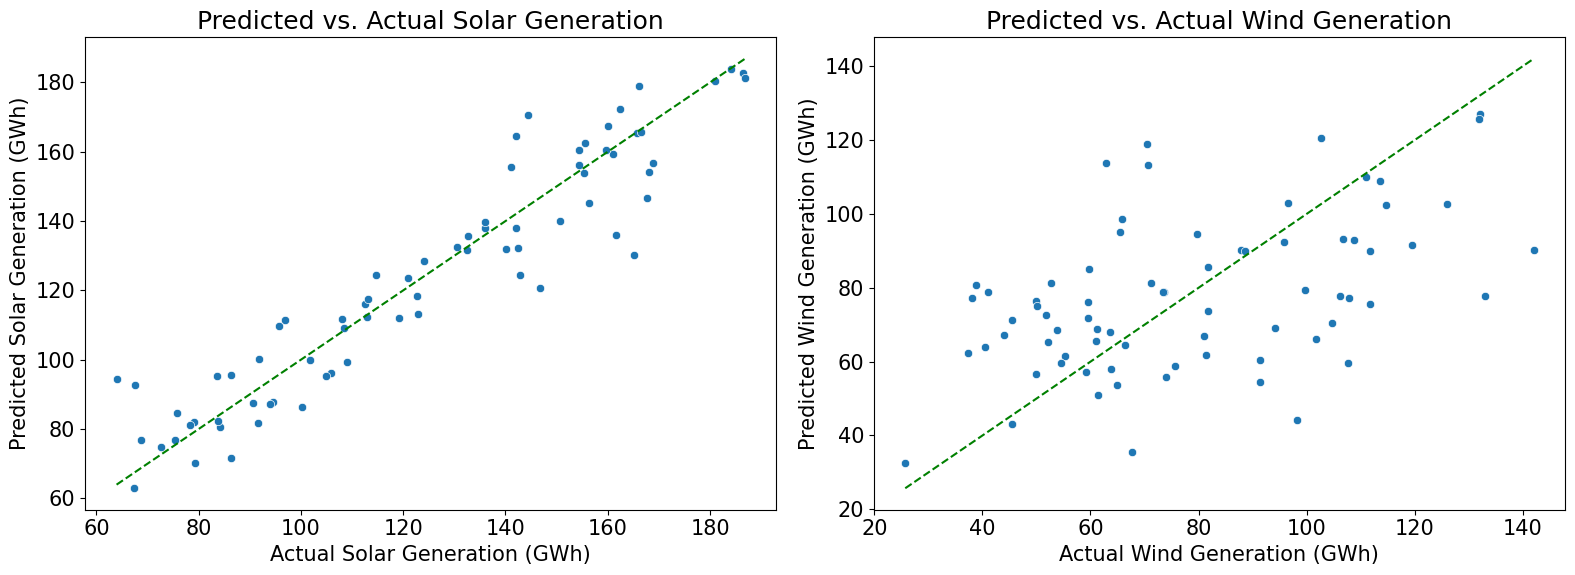

Solar MAE: 8.585127985706066
Wind MAE: 20.25294145767003


In [62]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
WeatherData_avg = WeatherData_df.groupby('DOY')[['T2M', 'ALLSKY_SFC_SW_DWN', 'WS50M_MAX', 'WS50M', 'WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for these parameters
EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

WeatherData_avg['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg['DOY'] / 365)  # Encode DOY as sin/cos for seasonality
WeatherData_avg['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg['DOY'] / 365)

X_solar = WeatherData_avg[['T2M', 'ALLSKY_SFC_SW_DWN' , 'DOY_sin', 'DOY_cos']]
y_solar = EnergyGeneration_clean_df['Solar (Utility) -  GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) -  GWh']

# Feature Scaling
scaler = StandardScaler()
X_solar_scaled = scaler.fit_transform(X_solar)

# Data split, train model, predict
X_train_solar, X_test_solar, y_train_solar, y_test_solar = train_test_split(X_solar_scaled, y_solar, test_size=0.2, random_state=42)

# Use XGBoost for Solar model
Solar_XG_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
Solar_XG_model.fit(X_train_solar, y_train_solar)
y_pred_solar = Solar_XG_model.predict(X_test_solar)






## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True]  # Just select data for wind farms
WeatherData_avg_wind = WeatherData_wind.groupby('DOY')[['WS10M_MAX']].mean().reset_index()  # Group by DOY and take the average for wind speed

# Encode DOY as sine and cosine components to capture seasonality
WeatherData_avg_wind['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)
WeatherData_avg_wind['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)

# Select the features for the model, including DOY components and wind speed
X_wind = WeatherData_avg_wind[['WS10M_MAX', 'DOY_sin', 'DOY_cos']] ** 3  # Wind generation is proportional to the cube of wind speed
y_wind = EnergyGeneration_clean_df['Wind -  GWh']

# Feature Scaling
X_wind_scaled = scaler.fit_transform(X_wind)

# Data split, train model, predict
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(X_wind_scaled, y_wind, test_size=0.2, random_state=42)

# Use XGBoost for Wind model
Wind_XG_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
Wind_XG_model.fit(X_train_wind, y_train_wind)
y_pred_wind = Wind_XG_model.predict(X_test_wind)






# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

# Print performance metrics
print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))


#### 3. Seasonal Autoregressive Integrated Moving Average (SARIMA)

Uses energy generation history rather than weather variables (e.g. solar radiance, wind speed) to forecast solar & wind generation. Should be able to capture trends and seasonality.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Assuming EnergyGeneration_df has a 'Date' column and required generation columns
# Convert to datetime and set as index
EnergyGeneration_df = pd.read_csv("2024EnergyGenerationAus.csv")
EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['date'])
EnergyGeneration_df.set_index('Date', inplace=True)

# Prepare Solar Time Series
solar_ts = EnergyGeneration_df['Solar (Utility) -  GWh'] + EnergyGeneration_df['Solar (Rooftop) -  GWh']

# Prepare Wind Time Series
wind_ts = EnergyGeneration_df['Wind -  GWh']



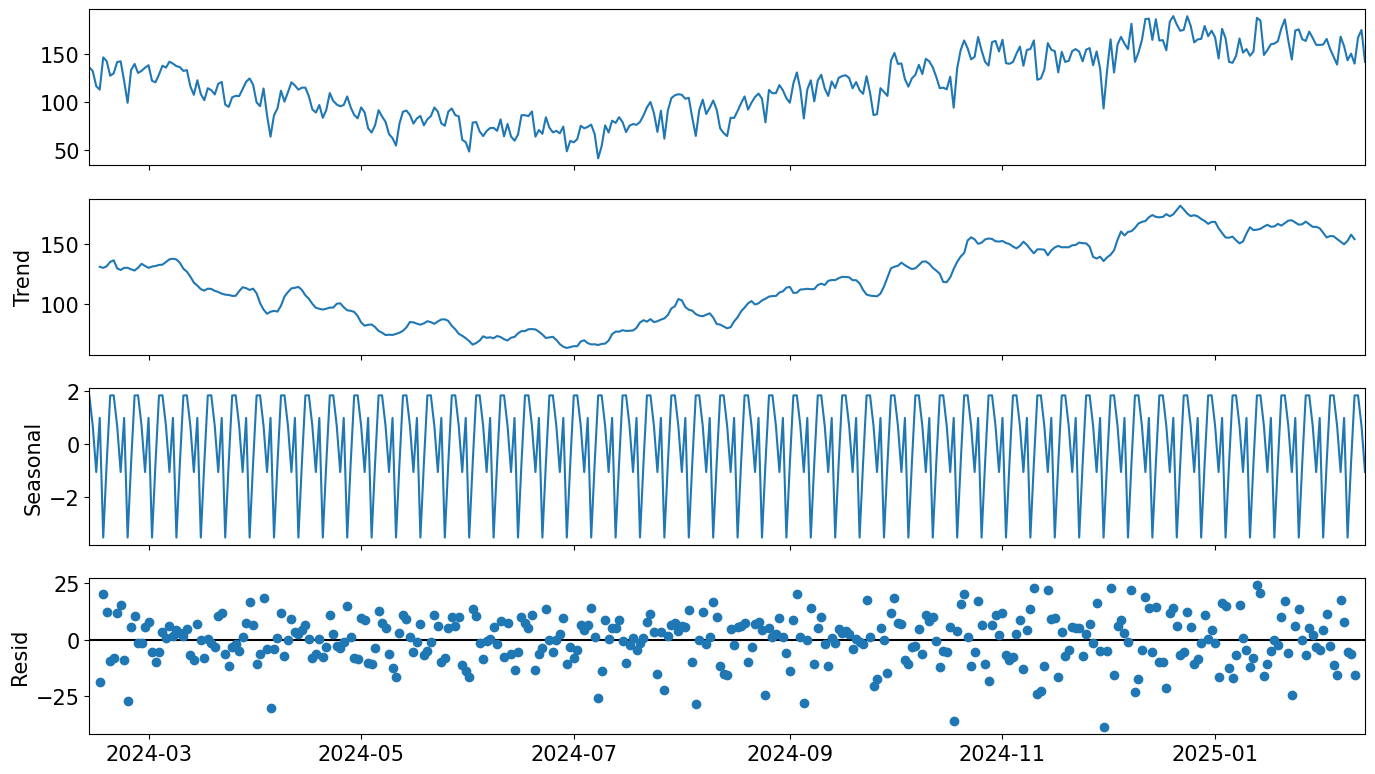

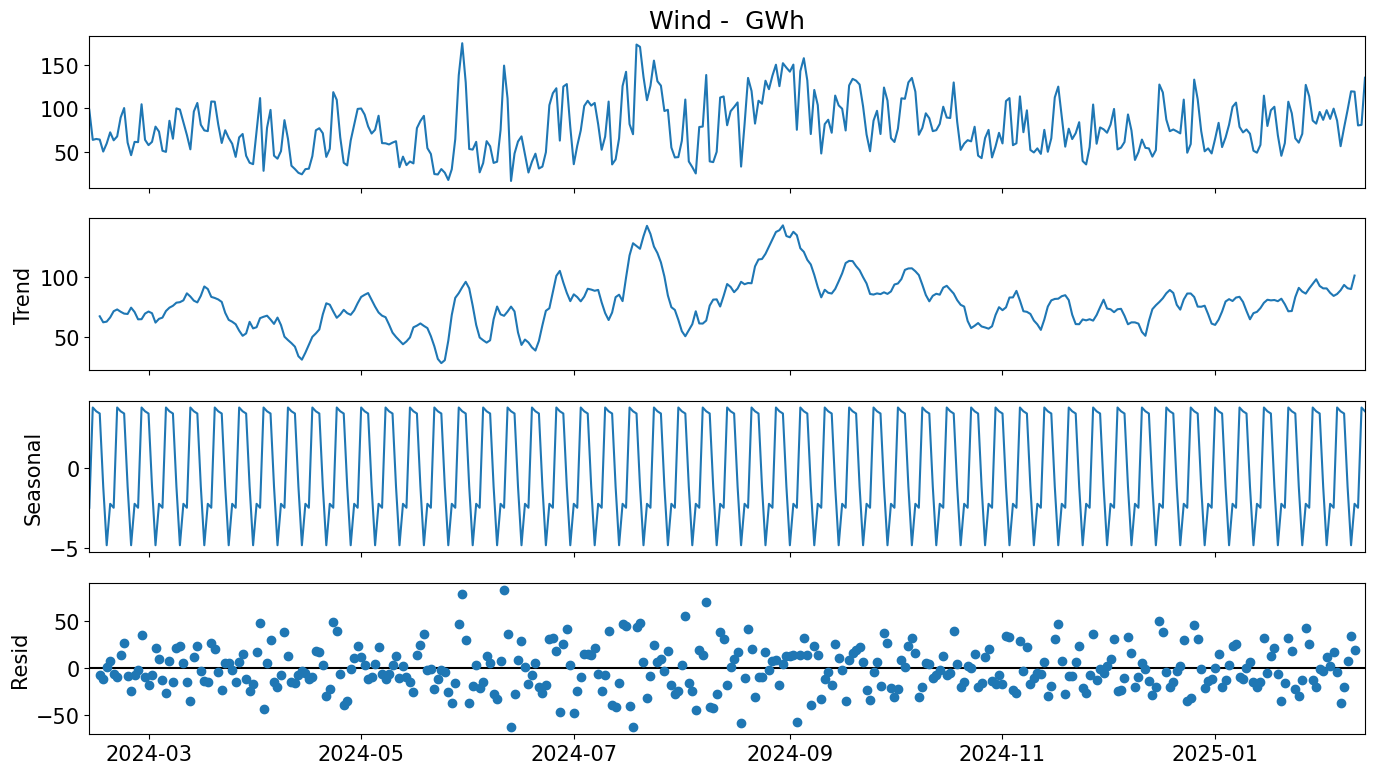

In [64]:
### Explore Time series to determine parameters for SARIMA model

## Check for seasonal differencing (D)
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose solar time series
result_solar = seasonal_decompose(solar_ts, model='additive')
result_solar.plot()

# Decompose wind time series
result_wind = seasonal_decompose(wind_ts, model='additive')
result_wind.plot()

plt.tight_layout()
plt.show()

## -- There is a clear seasonal trend for solar generation (12 month cycle) but not for wind generation -- ##

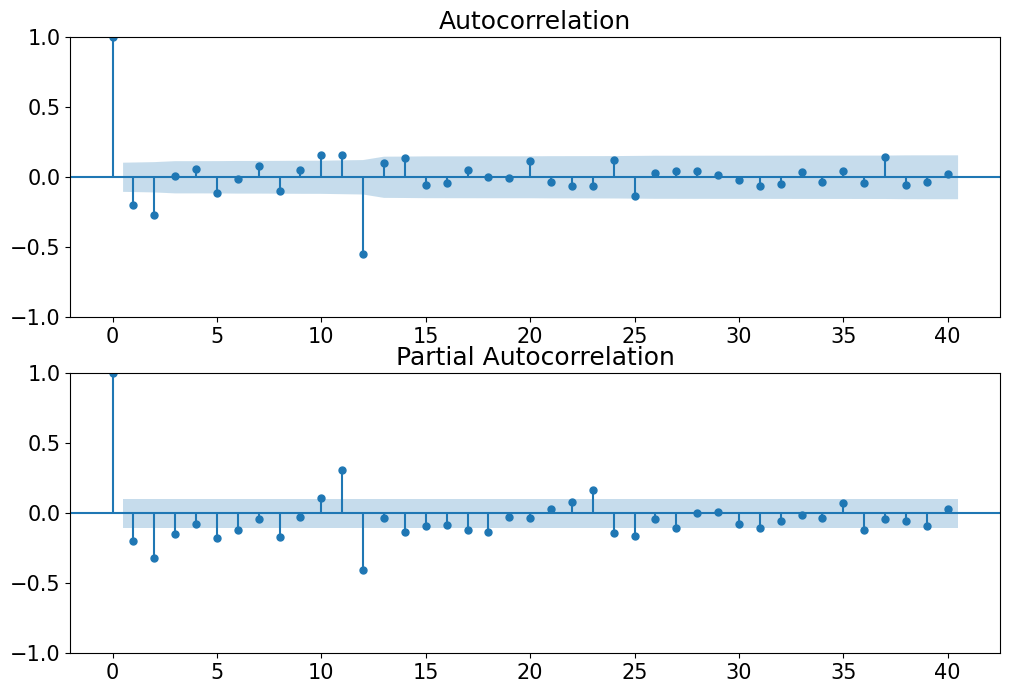

In [65]:
### For AR/MA order (p, q) determination, use ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Apply differencing
d = 1  
s = 12
D = 1 

stationary_series = solar_ts.diff(d).diff(s*D).dropna()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(stationary_series, lags=40, ax=ax[0])
plot_pacf(stationary_series, lags=40, ax=ax[1], method='ywm')
plt.show()

c:\Users\Tom\Documents\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\Documents\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\Documents\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\Documents\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  se

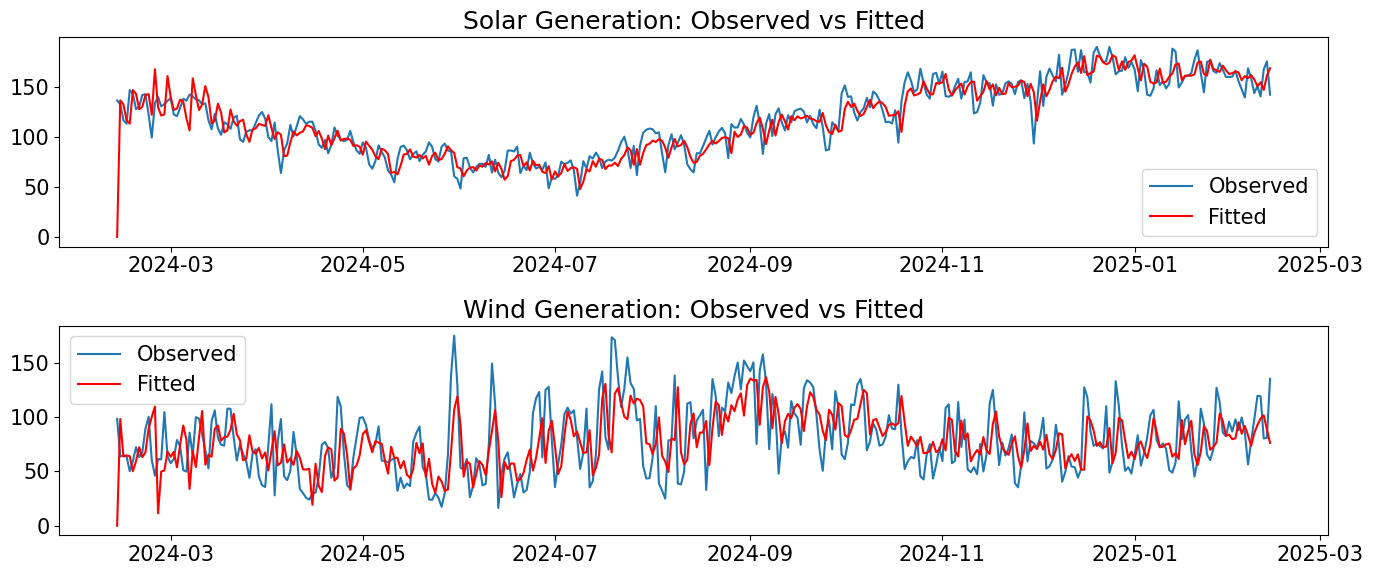

Solar MAE: 11.23 GWh
Wind MAE: 21.54 GWh


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Define SARIMA parameters (initial guess)
p, d, q = 1, 1, 1  # Non-seasonal AR, differencing, MA orders
P, D, Q, s = 1, 1, 1, 12  # Seasonal AR, differencing, MA orders, and seasonality (12 months)

# Fit SARIMA model for Solar
Solar_SARIMA_model = SARIMAX(solar_ts, order=(p, d, q), seasonal_order=(P, D, Q, s))
solar_results = Solar_SARIMA_model.fit(disp=False)

# Fit SARIMA model for Wind
Wind_SARIMA_model = SARIMAX(wind_ts, order=(p, d, q), seasonal_order=(P, D, Q, s))
wind_results = Wind_SARIMA_model.fit(disp=False)

# Plot results for Solar
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(solar_ts, label='Observed')
plt.plot(solar_results.fittedvalues, label='Fitted', color='red')
plt.title('Solar Generation: Observed vs Fitted')
plt.legend()

# Plot results for Wind
plt.subplot(2, 1, 2)
plt.plot(wind_ts, label='Observed')
plt.plot(wind_results.fittedvalues, label='Fitted', color='red')
plt.title('Wind Generation: Observed vs Fitted')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model performance (using Mean Absolute Error)
solar_mae = mean_absolute_error(solar_ts, solar_results.fittedvalues)
wind_mae = mean_absolute_error(wind_ts, wind_results.fittedvalues)

print(f"Solar MAE: {solar_mae:.2f} GWh")
print(f"Wind MAE: {wind_mae:.2f} GWh")


## Energy Forecasts/Predictions

Forecasts for expected solar and wind energy generation in Queensland using 3 models:

In [67]:
### Get required weather data for prediction
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": -27.4679,
	"longitude": 153.0281,
	"hourly": ["temperature_2m", "wind_speed_180m", "shortwave_radiation"],
	"daily": ["temperature_2m_max", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"timezone": "Australia/Sydney"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_speed_180m = hourly.Variables(1).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(2).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["wind_speed_180m"] = hourly_wind_speed_180m
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation

hourly_dataframe = pd.DataFrame(data = hourly_data)
# print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(1).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
# print(daily_dataframe)

Coordinates -27.5°N 153.0°E
Elevation 27.0 m asl
Timezone b'Australia/Sydney' b'GMT+11'
Timezone difference to GMT+0 39600 s


##### Linear Regression

In [74]:
### Forecasting Energy Generation using linear regression
daily_dataframe['DOY'] = daily_dataframe['date'].dt.dayofyear
daily_dataframe['DOY_sin'] = np.sin(2 * np.pi * daily_dataframe['DOY'] / 365)
daily_dataframe['DOY_cos'] = np.cos(2 * np.pi * daily_dataframe['DOY'] / 365)

daily_dataframe['T2M'] = daily_dataframe['temperature_2m_max']
daily_dataframe['ALLSKY_SFC_SW_DWN'] = daily_dataframe['shortwave_radiation_sum']
daily_dataframe['WS10M_MAX'] = daily_dataframe['wind_speed_10m_max']

# -- Solar -- #
x = daily_dataframe[['T2M','ALLSKY_SFC_SW_DWN', 'DOY_sin', 'DOY_cos']]
y_pred_solarLR = Solar_LR_model.predict(x)


# -- Wind -- #
x = daily_dataframe[['WS10M_MAX', 'DOY_sin', 'DOY_cos']] ** 3
y_pred_windLR = Wind_LR_model.predict(x)


print("Solar Generation Prediction:", y_pred_solarLR)
print("Wind Generation Prediction:", y_pred_windLR)

Solar Generation Prediction: [145.89517609 145.90595255 142.76859416 141.0119847  146.86539105
 143.38549618 138.79101548]
Wind Generation Prediction: [247.7599868  269.57775688 178.52010977 192.04188572 303.28162696
 470.75509258 412.27216557]


##### Gradient Boosting

In [75]:
### Forecasting Energy Generation using linear regression
# -- Solar -- #
x = daily_dataframe[['T2M','ALLSKY_SFC_SW_DWN', 'DOY_sin', 'DOY_cos']]
y_pred_solarGB = Solar_XG_model.predict(x)


# -- Wind -- #
x = daily_dataframe[['WS10M_MAX', 'DOY_sin', 'DOY_cos']] ** 3
y_pred_windGB = Wind_XG_model.predict(x)


print("Solar Generation Prediction:", y_pred_solarGB)
print("Wind Generation Prediction:", y_pred_windGB)

Solar Generation Prediction: [149.77795 149.75568 149.59552 149.59552 149.64331 149.64331 149.61017]
Wind Generation Prediction: [83.16856  78.90734  78.80934  78.80934  86.613495 86.601776 86.601776]


##### SARIMA

In [ ]:
# Perform SARIMA Forecasts
# -- Solar -- #
solar_forecast_sarima = solar_results.forecast(steps=7)  # Forecast for the next 12 periods (e.g., months)
# -- Wind -- #
wind_forecast_sarima = wind_results.forecast(steps=7)  # Same for wind


print("Solar Generation SARIMA Forecast:", solar_forecast_sarima)
print("Wind Generation SARIMA Forecast:", wind_forecast_sarima)

Solar Generation SARIMA Forecast: 2025-02-14    153.399364
2025-02-15    152.845944
2025-02-16    149.589707
2025-02-17    159.376895
2025-02-18    166.379625
2025-02-19    158.932500
2025-02-20    156.224815
2025-02-21    157.077196
2025-02-22    157.569147
2025-02-23    156.314056
2025-02-24    156.262591
2025-02-25    158.047720
Freq: D, Name: predicted_mean, dtype: float64
Wind Generation SARIMA Forecast: 2025-02-14    110.295176
2025-02-15    101.362881
2025-02-16     96.625754
2025-02-17     94.334004
2025-02-18     88.679048
2025-02-19     94.503920
2025-02-20     95.761755
2025-02-21     97.492081
2025-02-22     93.173597
2025-02-23     88.136929
2025-02-24     93.525053
2025-02-25     91.618836
Freq: D, Name: predicted_mean, dtype: float64
